In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.nn import DataParallel as geoDataParallel
from utils import load_dataset, COO_to_matrix, calculate_metric

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from glob import glob
from tqdm.auto import tqdm
import pandas as pd
import pickle

# set default figure/font format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
BIGGER_SIZE = 16
NORMAL_SIZE= 16
plt.rc('font', size=BIGGER_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NORMAL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NORMAL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NORMAL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


import networkx as nx
from sklearn import metrics
import pandas as pd

def Find_Optimal_Cutoff(target, predicted):
    # https://stackoverflow.com/a/56204455
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 



# Part 1. Synthetic Data on Synthetic Graphs

## - Test Density 

> Train a model on a graph with 100 nodes andtest it on a different graph of the same size but different densities.



In [43]:
from copy import deepcopy
from IPython.core.display import display

steps = [5, 10, 15, 20]
models = ['CVAE_UNET', 'CNN_nodes', 'CNN_time', 'MLP']

#
model_dispnames = ['DDmix', 'CNN-nodes', 'CNN-time','MLP']
mdisp = dict(zip(models, model_dispnames))

model_folder_path = "./models/exp_0/"      # PATH TO YOUR TRAINED MODEL HERE 
dataset_folder_path = "./datasets/exp_2/"  # PATH TO YOUR TEST DATA HERE 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gdensity = ['same', 'denser', 'sparser']


df_all = {den:None for den in gdensity}
res_all = {den:None for den in gdensity}

for i,ss in enumerate(['same', 'denser', 'sparser']):
    res_all[ss] = {
        'aidx':{},
        'pos':{},
        'yt':{},
        'yp':{}
    }
    
    data = []
    with tqdm(total=len(steps)*len(models),  desc=ss) as pbar:

        for step in steps:
            res_all[ss]['yt'][step] = {}
            res_all[ss]['yp'][step] = {}
            
            model = None
            torch.cuda.empty_cache()

            dataset_path = dataset_folder_path + "%d_steps/RG_%d_100nodes_%dsteps_1000sims.obj"%(step,i+1,step)
            _, validation_loader = load_dataset(dataset_path, 0, 1000, 1000)
            res_all[ss]['aidx'] = validation_loader.dataset[0].edge_index
            res_all[ss]['pos'] = validation_loader.dataset[0].pos

            curr_data = []

            for model_str in models:
                pbar.update(1)

                model_path = model_folder_path + "%s*/model.pt"%( model_str)
                model_path = glob(model_path)[0]

                model = torch.load(model_path)['net']
                model.eval()

                curr_metric,(yt, yp, aidx) = calculate_metric(model, validation_loader , return_pred=True)
                curr_data.append(curr_metric)
                
                res_all[ss]['yt'][step][model_str] = yt
                res_all[ss]['yp'][step][model_str] = yp
                
            data.append(curr_data)

        df = pd.DataFrame(data, columns=models, index=steps)
        df_all[ss] = df

        print(ss,':')
        display(df)

../models_exp/exp_1/5_steps/CVAE_UNET_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/CNN_nodes_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/CNN_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/MLP_nodes_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CVAE_UNET_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CNN_nodes_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CNN_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/MLP_nodes_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/15_steps/CVAE_UNET_rule_RG_5000sims_15timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/15_steps/C

CVAE_UNET  CNN_nodes     CNN  MLP_nodes
5      0.0409     0.0242  0.0773     0.2770
10     0.1014     0.1060  0.1426     0.2531
15     0.1463     0.1626  0.1556     0.2494
20     0.1772     0.1882  0.1944     0.2552

../models_exp/exp_1/5_steps/CVAE_UNET_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/CNN_nodes_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/CNN_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/MLP_nodes_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CVAE_UNET_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CNN_nodes_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CNN_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/MLP_nodes_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/15_steps/CVAE_UNET_rule_RG_5000sims_15timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/15_steps/C

CVAE_UNET  CNN_nodes     CNN  MLP_nodes
5      0.3685     0.2689  0.2448     0.2431
10     0.1602     0.2703  0.2669     0.2257
15     0.1727     0.2563  0.2551     0.2274
20     0.1968     0.2391  0.2398     0.2301

../models_exp/exp_1/5_steps/CVAE_UNET_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/CNN_nodes_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/CNN_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/5_steps/MLP_nodes_rule_RG_5000sims_5timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CVAE_UNET_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CNN_nodes_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/CNN_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/10_steps/MLP_nodes_rule_RG_5000sims_10timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/15_steps/CVAE_UNET_rule_RG_5000sims_15timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_1/15_steps/C

CVAE_UNET  CNN_nodes     CNN  MLP_nodes
5      0.0300     0.0157  0.0532     0.2807
10     0.0746     0.1766  0.1677     0.3114
15     0.1357     0.2111  0.2152     0.2893
20     0.2164     0.2324  0.2259     0.2834

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


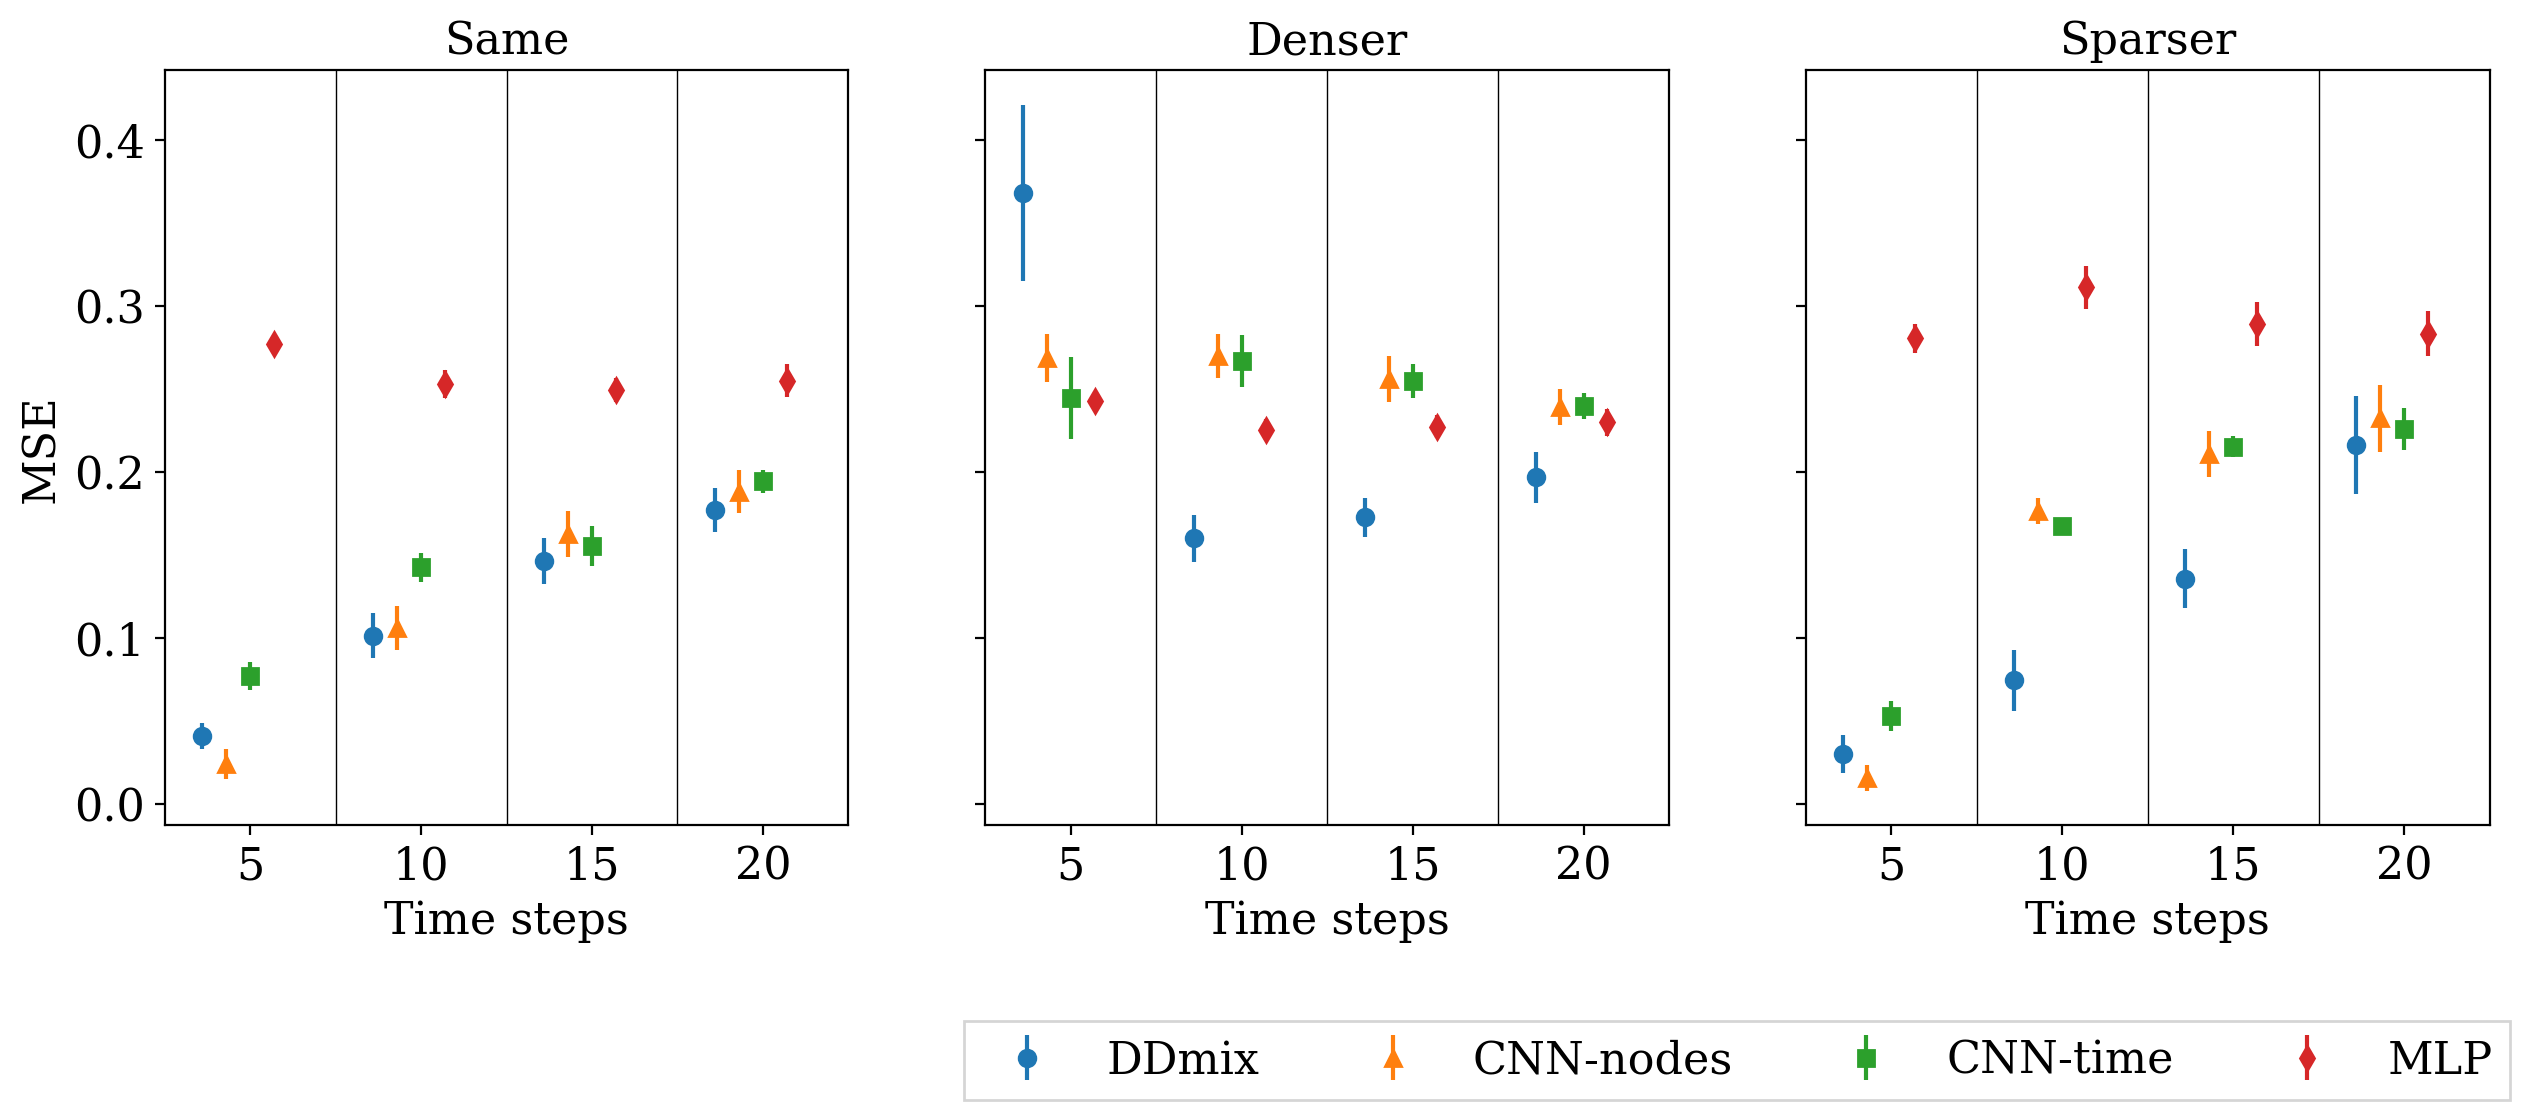

In [65]:

# prepare mean and std values for plot
perf ={}
for ss in gdensity:
    perf[ss] = {}
    for tt in steps:
        perf[ss][tt] = {}
        for ms in models:
            perf[ss][tt][ms] = {}
            mse = ((res_all[ss]['yt'][tt][ms]-res_all[ss]['yp'][tt][ms])**2).mean(-1).mean(-1)
            perf[ss][tt][ms]['mean'] = np.mean(mse)
            perf[ss][tt][ms]['std'] = np.std(mse)


# plot same, denser, and sparser error bars

fig, ax = plt.subplots(1, 3, figsize=(15,5),dpi=200, sharey=True)

# xx = range(len(steps))
markers = ['o','^','s','d']

for si,ss in enumerate(gdensity):
    for ii,ms in enumerate(models):
        y_m = [perf[ss][tt][ms]['mean'] for tt in steps]
        y_e = [perf[ss][tt][ms]['std'] for tt in steps]
        # plt.plot(xx,y_m,'o')
        ax[si].errorbar([tt+.7*(ii-2) for tt in steps], y_m, y_e, linestyle='None', marker=markers[ii], label=mdisp[ms])
    
    for xc in k2:
        ax[si].axvline(x=xc+2.5, color='k', linestyle='-', linewidth=.5)
        
    ax[si].set_xticks(k2,k2)#, rotation=30)
    ax[si].set_xlabel('Time steps')
    ax[si].set_xlim([k2[0]-2.5,k2[-1]+2.5])
    ax[si].set_title(ss[0].upper()+ss[1:].lower())
    
ax[0].set_ylabel('MSE')
plt.legend(loc='upper center', bbox_to_anchor=(-.1, -0.23), fancybox=False, shadow=False, ncol=4)

plt.show()

In [255]:
np.std(mse), np.mean(mse)

(0.029305004, 0.21650662)

## - Test Graph Size

> Train the models on a graph with 100 nodes and test them on graphs of different size (M = {100, 250, 500, 1000})

In [83]:

nodes = [100, 250, 500, 1000]
models = ['CVAE_UNET', 'CNN_nodes', 'CNN_time', 'MLP']
step = 20

#
model_dispnames = ['DDmix', 'CNN-nodes', 'CNN-time','MLP']
mdisp = dict(zip(models, model_dispnames))

model_folder_path = "./models/exp_0/"       # PATH TO YOUR TRAINED MODEL HERE 
dataset_folder_path = "./datasets/exp_3/"   # PATH TO YOUR TEST DATA HERE 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = []

res_all = {
    'aidx':{},
    'pos':{},
    'yt':{},
    'yp':{}
}

with tqdm(total=len(nodes)*len(models)) as pbar:
    
    for node in nodes:
        res_all['yt'][node] = {}
        res_all['yp'][node] = {}

        if node==100:
            dataset_path = "./datasets/exp_2/%d_steps/RG_1_100nodes_%dsteps_1000sims.obj"%(step,step)
        else:
            dataset_path = dataset_folder_path + str(node) + "_nodes/RG_" + str(node) + "nodes_%dsteps_1000sims.obj"%step 
        _, validation_loader = load_dataset(dataset_path,0,1000,100, device)
        
        # this is valid only if the graph is unified
        res_all['aidx'][node] = validation_loader.dataset[0].edge_index
        res_all['pos'][node] = validation_loader.dataset[0].pos

        curr_data = []

        for model_str in models:
            pbar.update(1)
            model = None
            torch.cuda.empty_cache()            
            
            model_path = model_folder_path +  model_str + "*/model.pt"
            model_path = glob(model_path)[0]
            print(model_path)

            model = torch.load(model_path, map_location=device)['net']
            model.eval()

            try:
                curr_metric, (yt, yp, aidx)= calculate_metric(model, validation_loader, device=None, weighted=False, is_1D=False,return_pred=True)
                curr_data.append(curr_metric)
                
                res_all['yt'][node][model_str] = yt
                res_all['yp'][node][model_str] = yp
            except:
                curr_metric, (yt, yp, aidx)= calculate_metric(model, validation_loader, device=None, weighted=False, is_1D=False,return_pred=True)                
                curr_data.append(np.nan)
                continue
                
        data.append(curr_data)
    
df = pd.DataFrame(data, columns=model_dispnames, index=nodes)
display(df)



../models_exp/exp_3/100_nodes/CVAE_UNET_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/CNN_nodes_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/CNN_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/MLP_nodes_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/CVAE_UNET_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/CNN_nodes_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/CNN_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/MLP_nodes_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp/exp_3/100_nodes/CVAE_UNET_rule_RG_5000sims_20timesteps_4batch_50epochs_1.00e-02lr_1.00e-06l2_.pt
../models_exp

DDmix  CNN-nodes  CNN-time     MLP
5   0.1771     0.1882    0.1944  0.2552
10  0.1749     0.1977    0.1973  0.2393
15  0.1821     0.2095    0.2062  0.2564
20  0.2177     0.2309    0.2291  0.2712

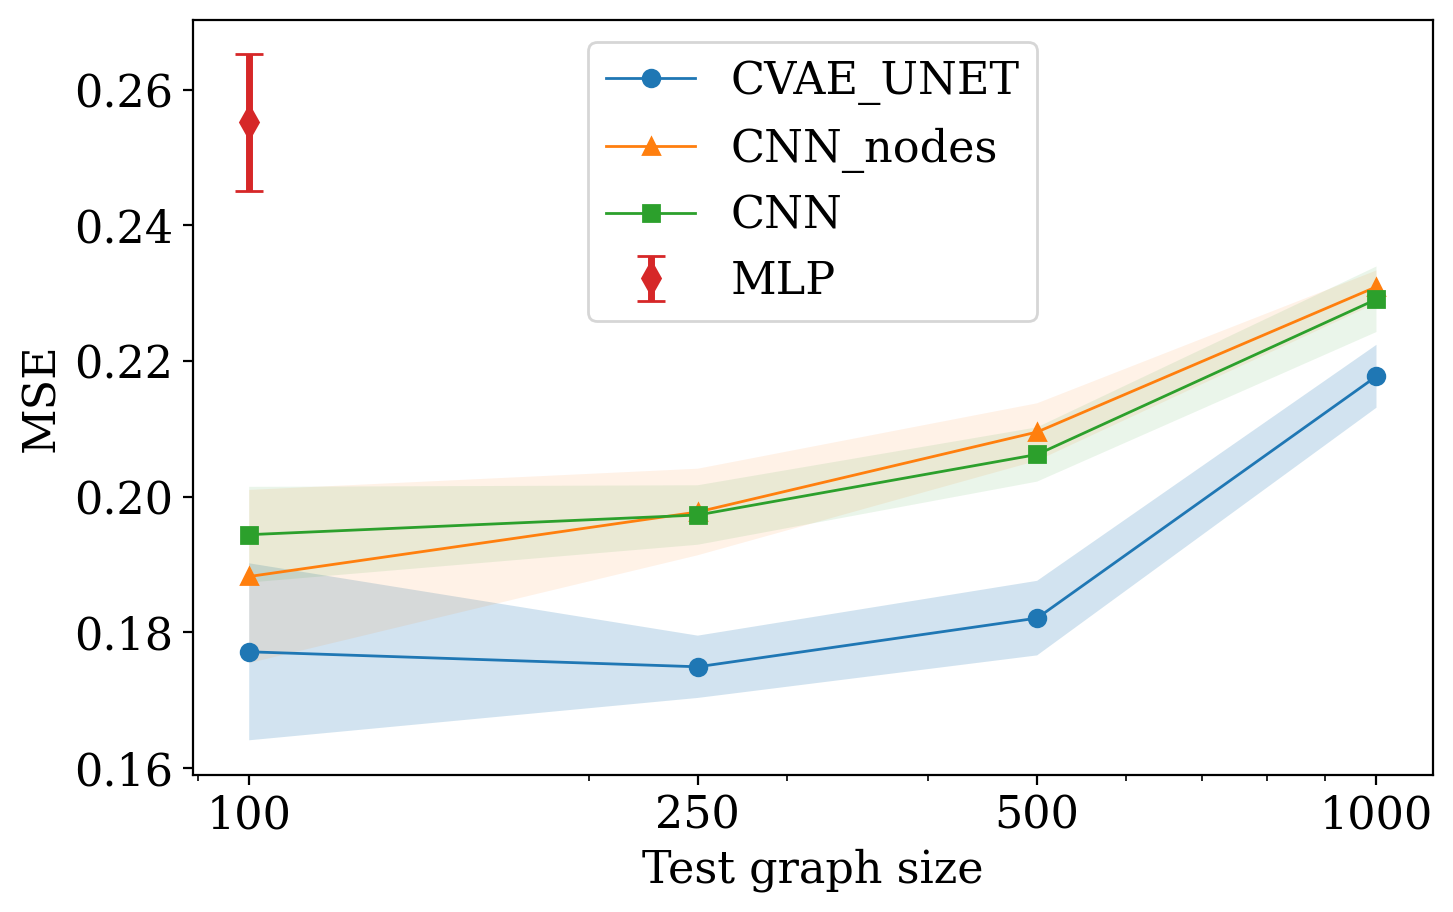

In [84]:
# prepare mean and std values for plot
perf ={}
for nn in nodes:
    perf[nn] = {}
    for ms in models:
        perf[nn][ms] = {}
        mse = ((res_all['yt'][nn][ms]-res_all['yp'][nn][ms])**2).mean(-1).mean(-1)
        perf[nn][ms]['mean'] = np.mean(mse)
        perf[nn][ms]['std'] = np.std(mse)

k4_1 = nodes
k4_2 = models

# clrs = sns.color_palette("husl", 4)
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o','^','s','d']

fig, ax = plt.subplots(figsize=(8,5), dpi=200)

for ii,ms in enumerate(models):
    if not 'MLP' in ms:
        y_m = np.array([perf[nn][ms]['mean'] for nn in nodes])
        y_e = np.array([perf[nn][ms]['std'] for nn in nodes])

        plt.plot(k4_1, y_m,color=clrs[ii], label=ms, marker=markers[ii], markersize=6, linewidth=1)
        plt.fill_between(nodes, y_m-y_e, y_m+y_e, alpha=.15+(-1)**(int(ii!=0))*.05, 
                         edgecolor='None', facecolor=clrs[ii],linewidth=0)
   
    else:
        y_m = np.array([perf[nn][ms]['mean'] for nn in nodes[:1]])
        y_e = np.array([perf[nn][ms]['std'] for nn in nodes[:1]])
        plt.errorbar(nodes[0], y_m, y_e, linestyle='None', marker=markers[ii], color=clrs[ii], 
                     label=mdisp[ms], markersize=8, linewidth=1, capsize=5, elinewidth=2.5)
        
ax.legend()
ax.set_xlabel('Test graph size')
ax.set_ylabel('MSE')
ax.set_xscale('log')

ax.set_xticks(nodes)
ax.set_xticklabels(nodes)
ax.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()



# - Test Training-set Size

use less training samples: num train = {0,4,8,16, 32, 50, 100,250, 500,1000,2000,4500}

In [ ]:

num_train = [0,4,8,16, 32, 50, 100,250, 500,1000,2000,4500]
models = ['CVAE_UNET', 'CNN_nodes', 'CNN_time', 'MLP']
steps = 20
#
model_dispnames = ['DDmix', 'CNN-nodes', 'CNN-time','MLP']
mdisp = dict(zip(models, model_dispnames))

model_folder_path = "../models_exp/exp_8/"
dataset_folder_path = "../datasets/exp_2/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = []

res_all = {
    'aidx':{},
    'pos':{},
    'yt':{},
    'yp':{}
}

with tqdm(total=len(num_train)*len(models)) as pbar:

    dataset_path = dataset_folder_path + str(steps) + "_steps/RG_1_100nodes_20steps_1000sims.obj"
    _, validation_loader = load_dataset(dataset_path,0,1000,100, device)

    # this is valid only if the graph is unified
    res_all['aidx'] = validation_loader.dataset[0].edge_index
    res_all['pos'] = validation_loader.dataset[0].pos    
        
    for n_tr in num_train:
        res_all['yt'][n_tr] = {}
        res_all['yp'][n_tr] = {}

        curr_data = []

        for model_str in models:
            pbar.update(1)
            model = None
            torch.cuda.empty_cache()            
            
            model_path = model_folder_path + str(n_tr) + "_ntrain/" + model_str+"*/model.pt"
            model_path = glob(model_path)[0]
            print(model_path)

            model = torch.load(model_path, map_location=device)['net']

            model.to(device)
            model.eval()

            curr_metric,(yt, yp, aidx) = calculate_metric(model, validation_loader, device=device, 
                                       weighted=False, is_1D=False, return_pred=True)
            curr_data.append(curr_metric)
            res_all['yt'][n_tr][model_str] = yt
            res_all['yp'][n_tr][model_str] = yp
                
        data.append(curr_data)
    
df = pd.DataFrame(data, columns=model_dispnames, index=num_train)
display(df)

# save results for reuse
with open('./resvis/exp8.obj', 'wb') as filehandler:
    pickle.dump({'df': df, 'res_all': res_all}, filehandler)




In [86]:
df

DDmix  CNN-nodes  CNN-time     MLP
0     0.2608     0.2889    0.2767  0.2760
4     0.2358     0.2469    0.2305  0.2571
8     0.1814     0.2264    0.2093  0.2613
16    0.1806     0.2034    0.2112  0.2565
32    0.1813     0.1963    0.2021  0.2569
50    0.1837     0.1878    0.2024  0.2571
100   0.1813     0.1865    0.2163  0.2574
250   0.1798     0.1872    0.2073  0.2571
500   0.1809     0.1867    0.1850  0.2566
1000  0.1772     0.1873    0.1994  0.2567
2000  0.1795     0.1873    0.1964  0.2567
4500  0.1773     0.1882    0.1944  0.2552

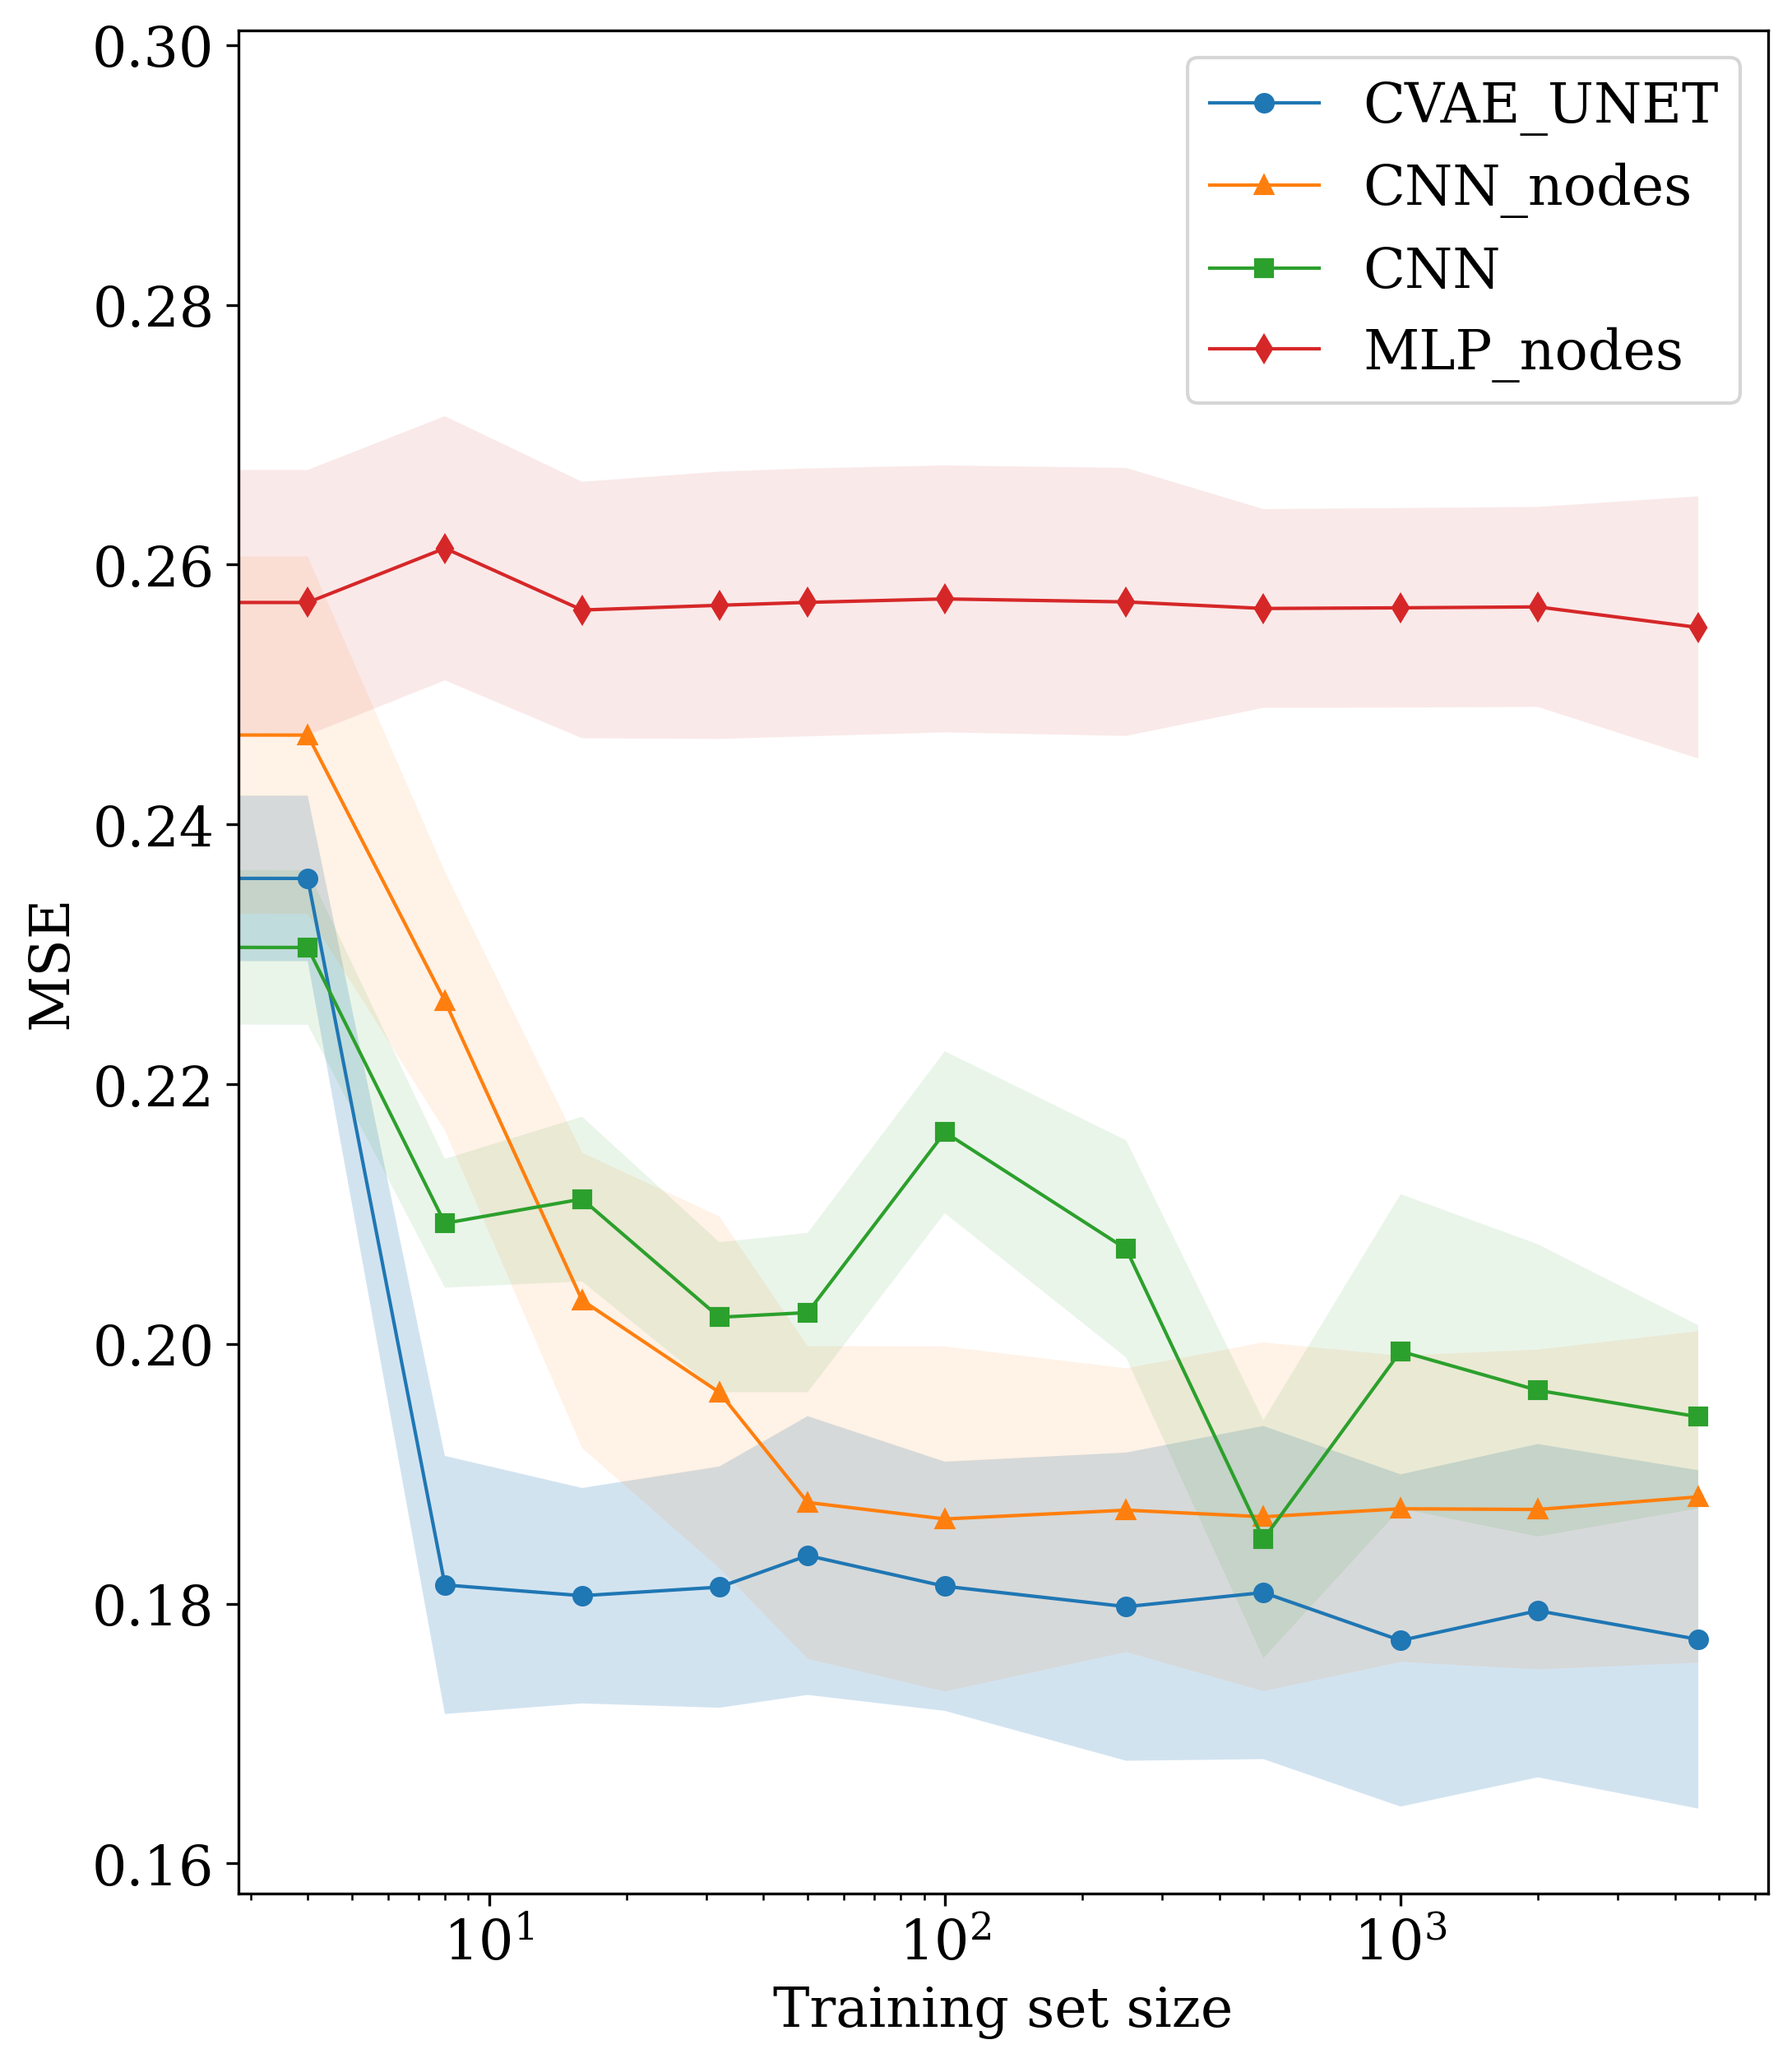

In [90]:
# prepare mean and std values for plot
perf ={}
for nn in num_train:
    perf[nn] = {}
    for ms in models:
        perf[nn][ms] = {}
        mse = ((res_all['yt'][nn][ms]-res_all['yp'][nn][ms])**2).mean(-1).mean(-1)
        perf[nn][ms]['mean'] = np.mean(mse)
        perf[nn][ms]['std'] = np.std(mse)

k1 = num_train
k2 = models

fig, ax = plt.subplots(figsize=(10,10), dpi=300)
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
   
for ii,ms in enumerate(k2):
    
    y_m = np.array([perf[nn][ms]['mean'] for nn in k1])
    y_e = np.array([perf[nn][ms]['std'] for nn in k1])
    
    plt.plot(k1, y_m,color=clrs[ii], label=ms, marker=markers[ii], markersize=5, linewidth=1)
    plt.fill_between(k1, y_m-y_e, y_m+y_e, alpha=.15+(-1)**(int(ii!=0))*.05, edgecolor='None', facecolor=clrs[ii],linewidth=0)


ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Training set size')
ax.set_ylabel('MSE')

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend()

In [244]:
df

CVAE_UNET  CNN_nodes       CNN  MLP_nodes
0     0.077388   0.180229  0.169526   0.254629
1     0.104378   0.187173  0.169018   0.259367
2     0.084312   0.174363  0.171125   0.256021
3     0.077699   0.174918  0.168176   0.238635
4     0.101236   0.180570  0.170599   0.257458
..         ...        ...       ...        ...
995   0.074788   0.186423  0.165110   0.251655
996   0.072792   0.166275  0.169281   0.244877
997   0.040622   0.165260  0.164346   0.253149
998   0.068435   0.164072  0.166901   0.248219
999   0.071671   0.185584  0.168844   0.265900

[1000 rows x 4 columns]

# Synthetic Data on Real Graphs

## 1) visualize graph data

For data used in this experiment, chekc out [`./SIRS_outbreak_real.ipynb`](./SIRS_outbreak_real.ipynb) for details.

## 2) experiment results (node mse/roc)

In [3]:
models = ['CVAE_UNET', 'CNN_nodes', 'CNN_time']#, 'MLP']
model_dispnames = ['DDmix', 'CNN-nodes', 'CNN-time']#,'MLP']
mdisp = dict(zip(models, model_dispnames))

steps = [20]
model_folder_path = "./models/exp_10/"
dataset_folder_path = "./datasets/exp_10/"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = []
res_all = {
    'aidx':{},
    'pos':{},
    'yt':{},
    'yp':{}
}

for step in steps:
    dataset_path = "../datasets/exp_10/20_steps/REAL_wCLS_M_ExclT_5edgethresh_226nodes_20steps_5000sims.obj"
    _, validation_loader = load_dataset(dataset_path, 1000,1000,1000, device=device)
    
    # this is valid only if the graph is unified
    res_all['aidx'] = validation_loader.dataset[0].edge_index
    res_all['pos'] = validation_loader.dataset[0].pos   
    
    curr_data = []
    
    for model_str in models:
        model = None
        torch.cuda.empty_cache()
       
        model_path = model_folder_path + str(step) + "_steps/" + model_str + "_rule_RG*.pt"  
        model_path = glob(model_path)[0]
        print(model_path)

        model = torch.load(model_path, map_location=device)['net']
        model.eval()
        model.to(device)

        curr_metric, (yt, yp, aidx)= calculate_metric(model, validation_loader, T=step, is_1D=False,return_pred=True)
        
        res_all['yt'][model_str] = yt
        res_all['yp'][model_str] = yp

        score = np.mean((yt-yp)**2)    
        curr_data.append(score)
    
    data.append(curr_data)
    
df = pd.DataFrame(data, columns=models, index=steps)

display(df)
    
print(res_all.keys())
display(df)

dict_keys(['aidx', 'pos', 'yt', 'yp', 'cls'])


CVAE_UNET  CNN_nodes       CNN
20   0.116473   0.098474  0.101217

... This (MSE over all steps) looks frustrating, but it doesn't matter! One can argue that in an epidemic, days 5-15 (or something alike; I haven't got a chance to test other schemes) mark the "rapidly disseminating phase" which is a period that's more important than the rest. And so it's most important that our model gets that period well. (This's what I was going to say in the paper if we had to put up this kinda quantitative results.) If we look into those models' performance... Good! DDmix is the best.

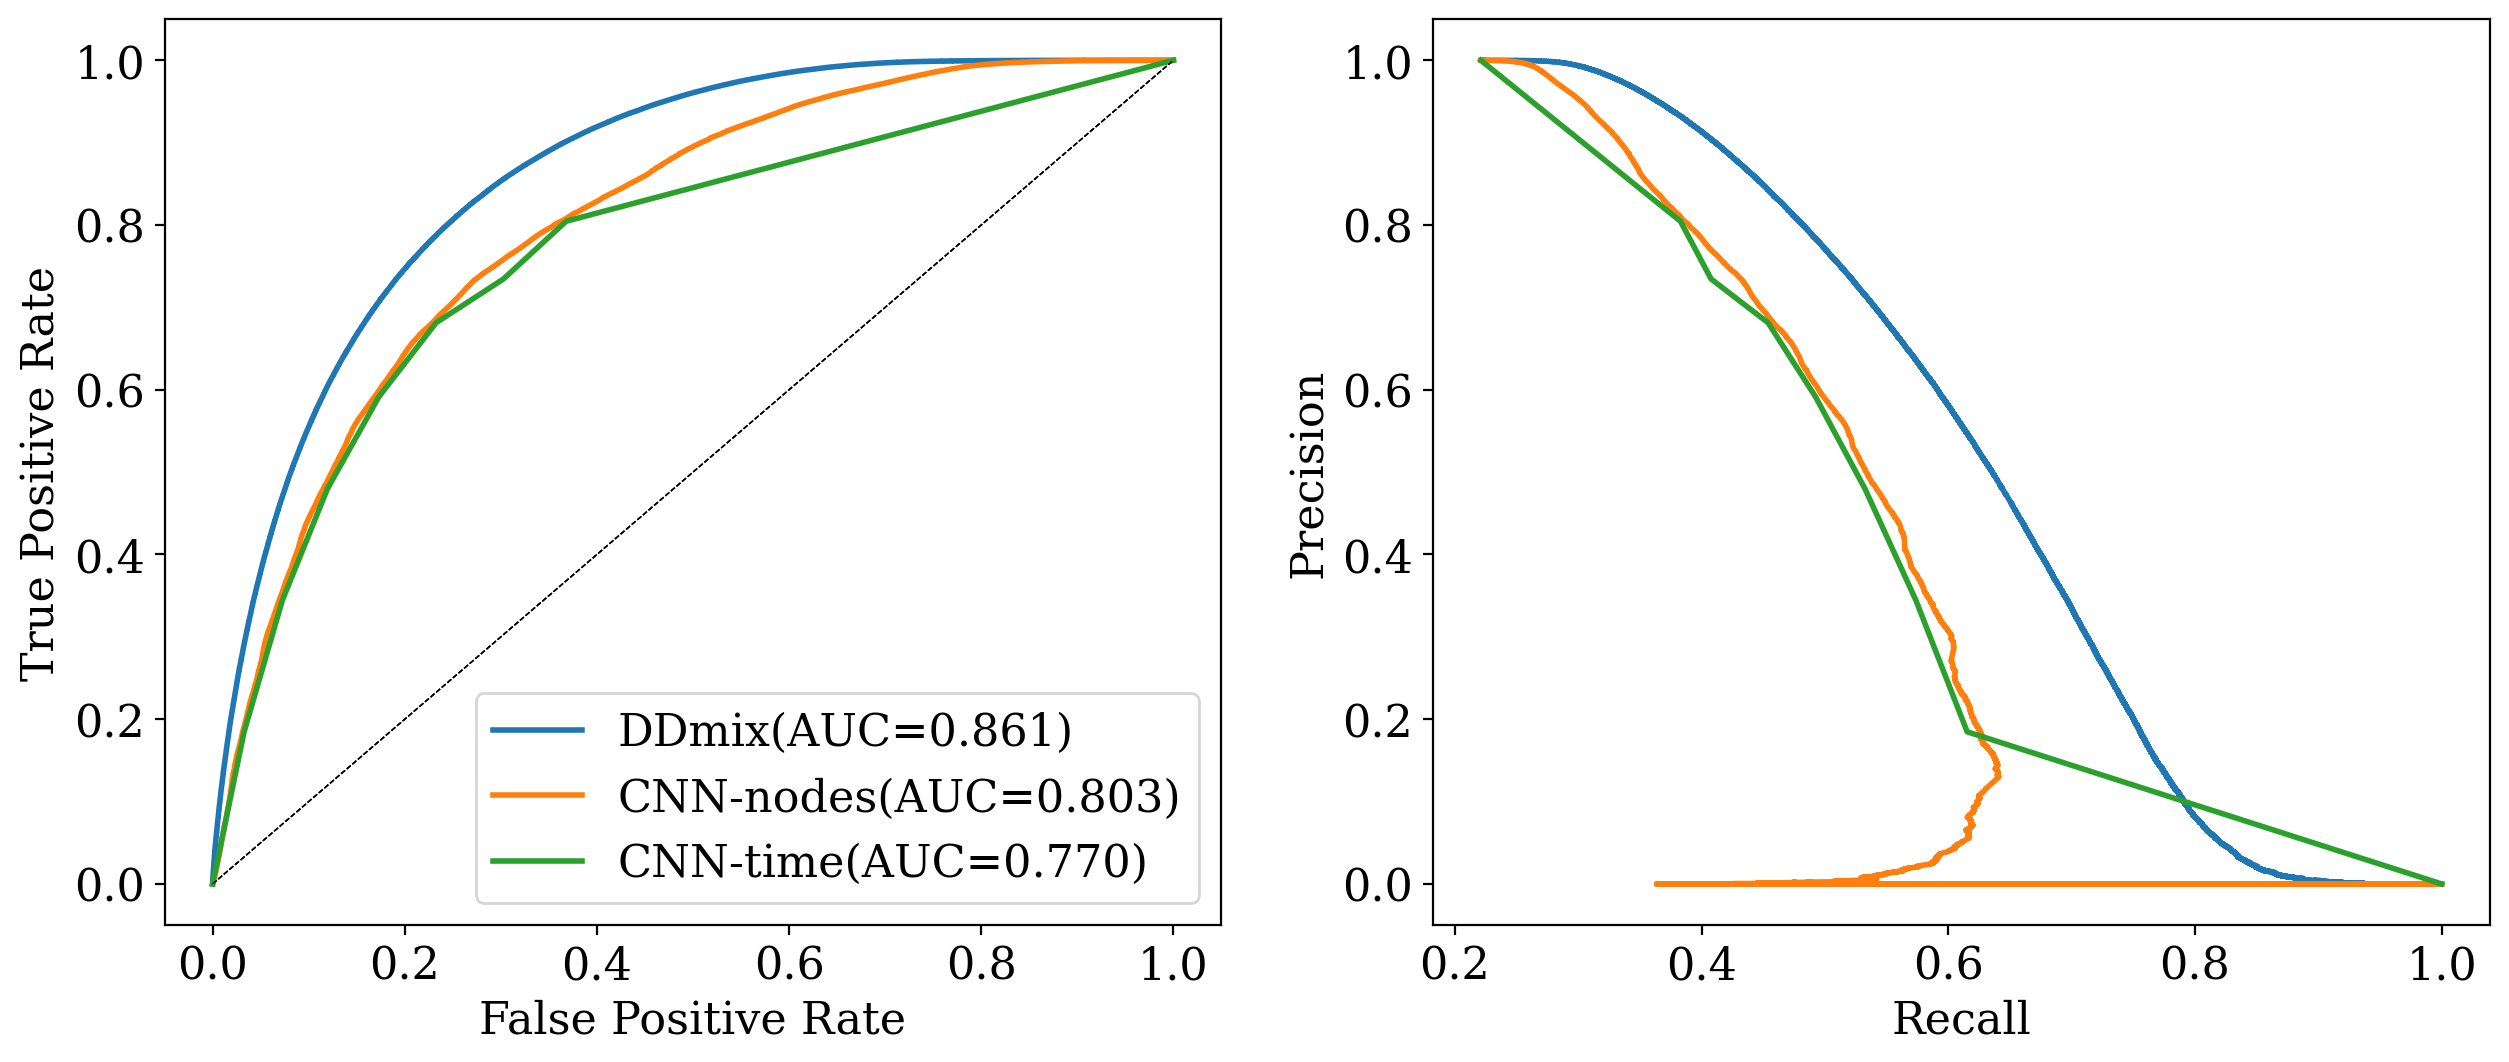

In [4]:

fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=200)

lstyle = ['-','--']
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

for mm,mstr in enumerate(models):
    y_true   = res_all['yt'][mstr][...,5:15].flatten()
    y_probas = res_all['yp'][mstr][...,5:15].flatten()
    
    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
    auc = metrics.roc_auc_score(y_true, y_probas)
    
    l_str = r'%s(AUC=%0.3f)'%(mdisp[mstr],auc)
    ax[0].plot(fpr, tpr, color = clrs[mm], label = l_str, linewidth=2)
    
    ax[0].plot([0, 1], [0, 1],'k--', linewidth=.5)
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].legend()    
        
    # PR curve
    precision, recall, _ = metrics.precision_recall_curve(y_true,  y_probas)
    ax[1].plot(precision, recall, color = clrs[mm], linewidth=2)
        
    ax[1].set_ylabel('Precision')
    ax[1].set_xlabel('Recall')
    
plt.show()


## 3) visualize graphs over stepwise reconstruction

	Ground Truth (sample#723)		DDmix			CNN-nodes			CNN-time
0 :


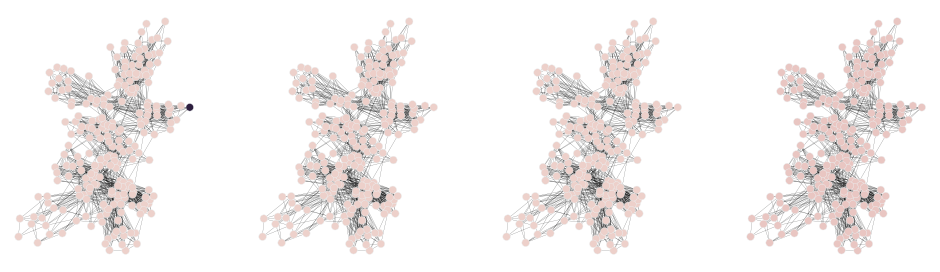

1 :


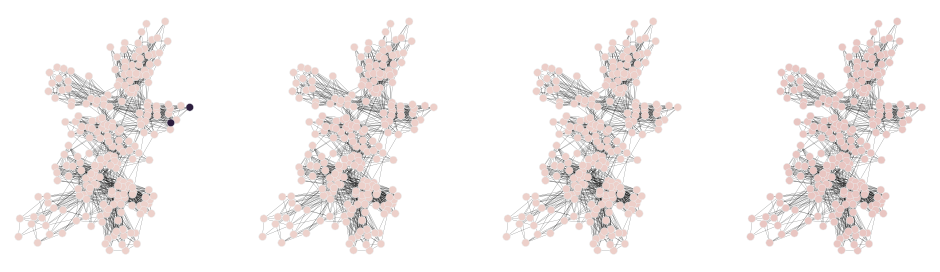

2 :


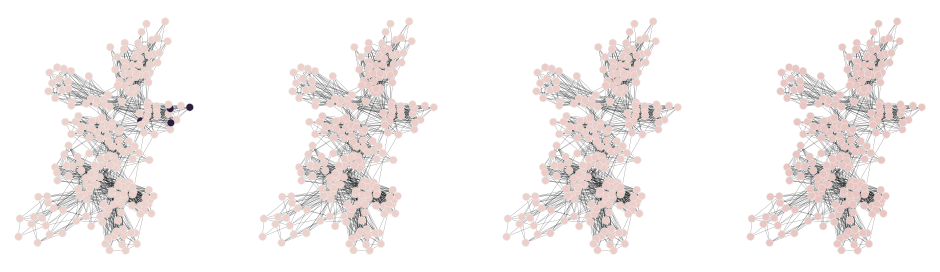

3 :


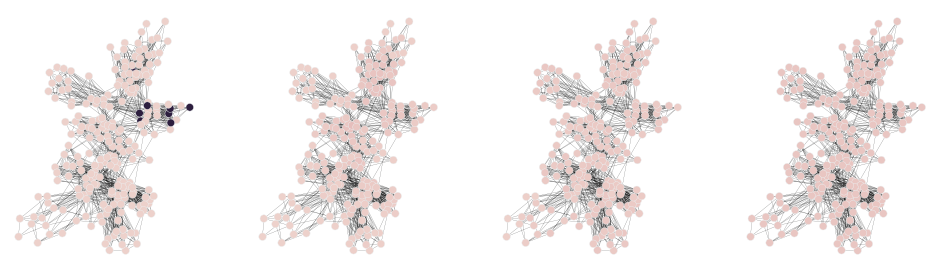

4 :


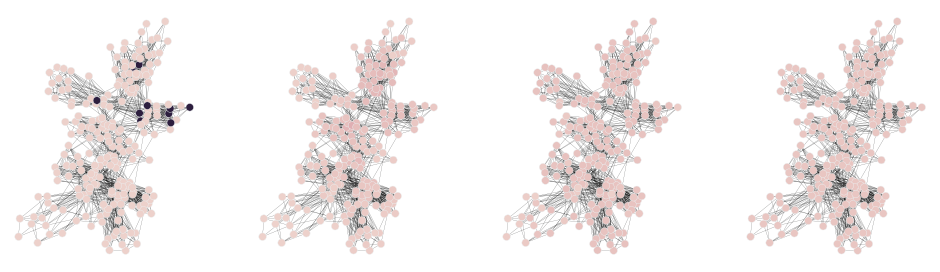

5 :


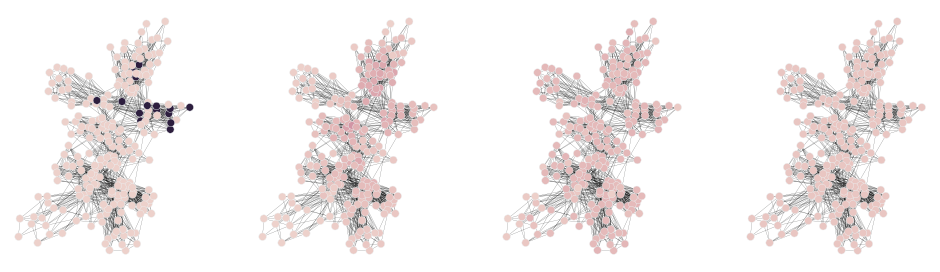

6 :


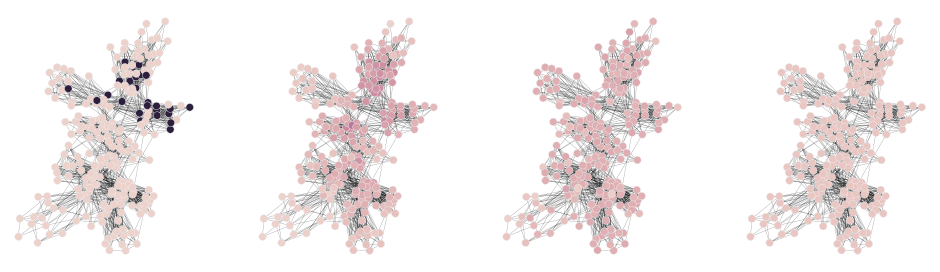

7 :


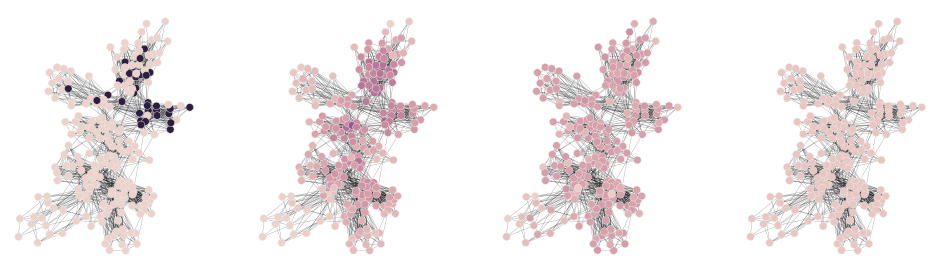

8 :


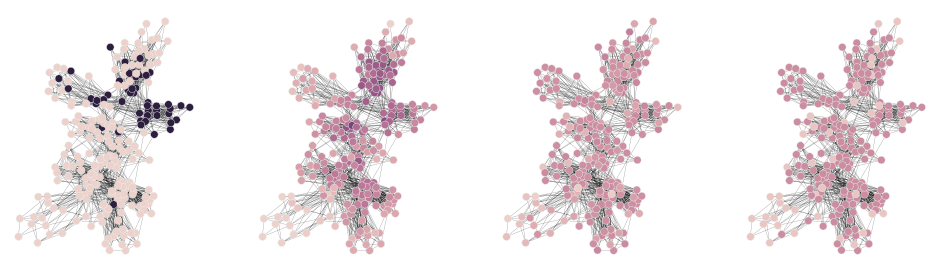

9 :


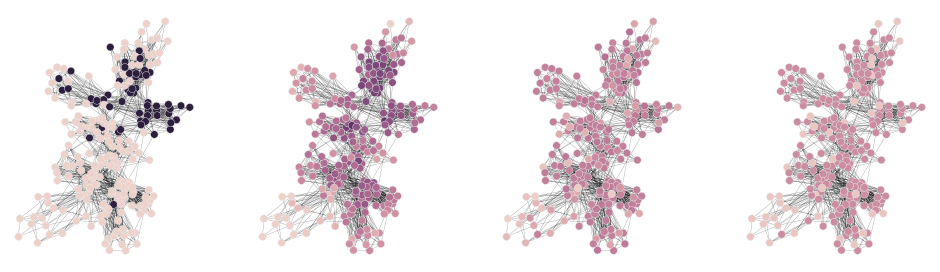

10 :


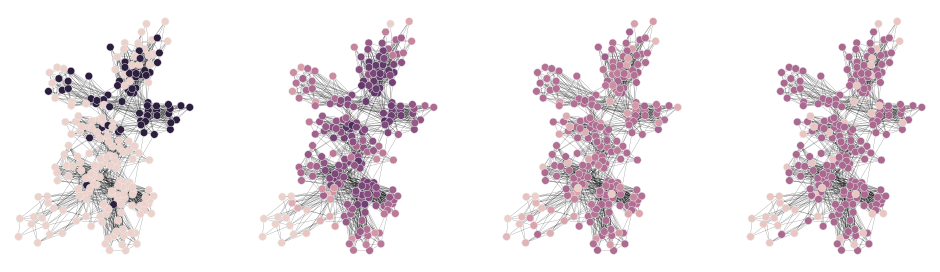

11 :


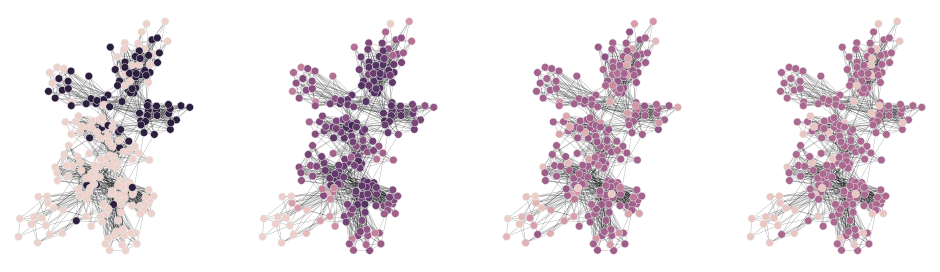

12 :


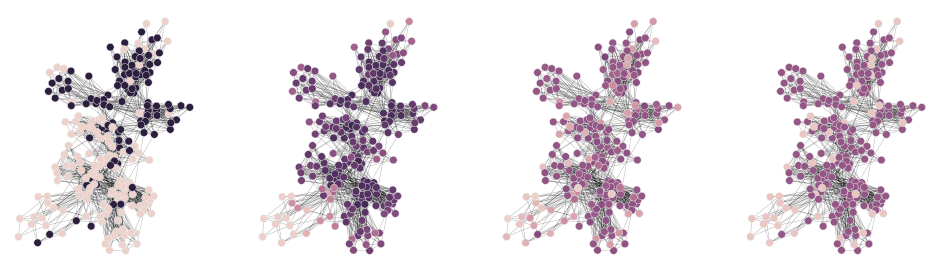

13 :


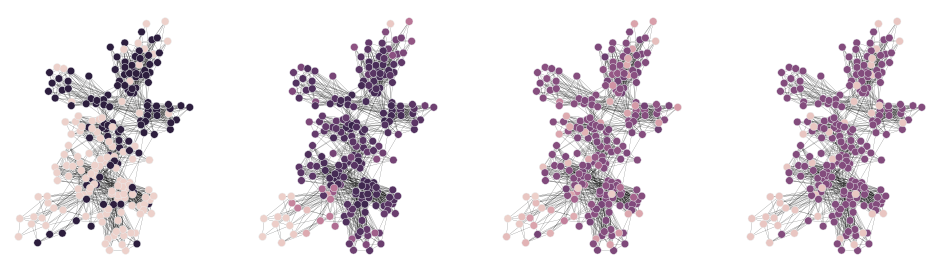

14 :


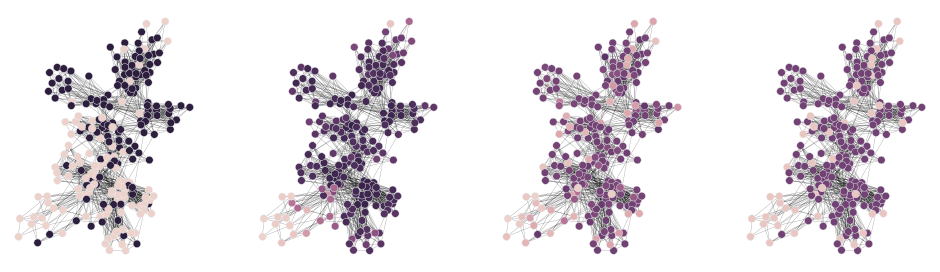

15 :


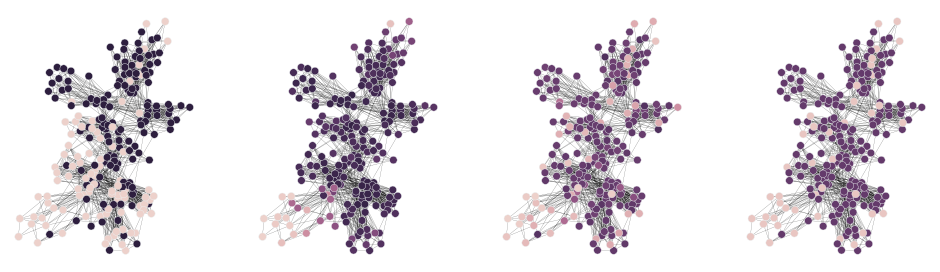

16 :


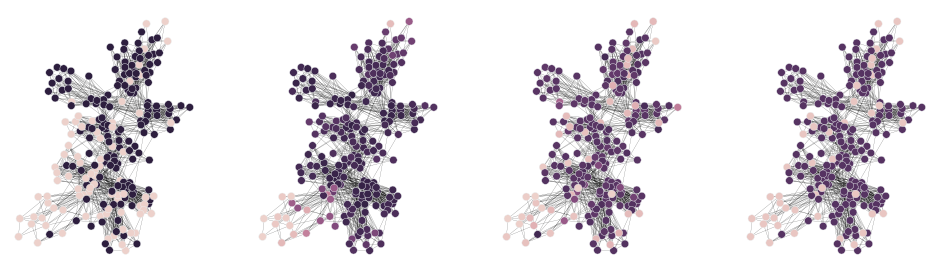

17 :


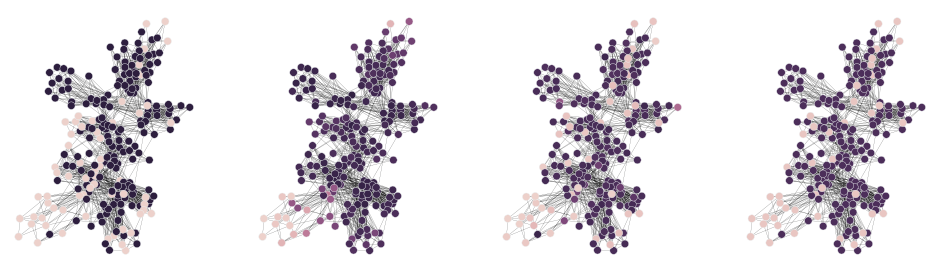

18 :


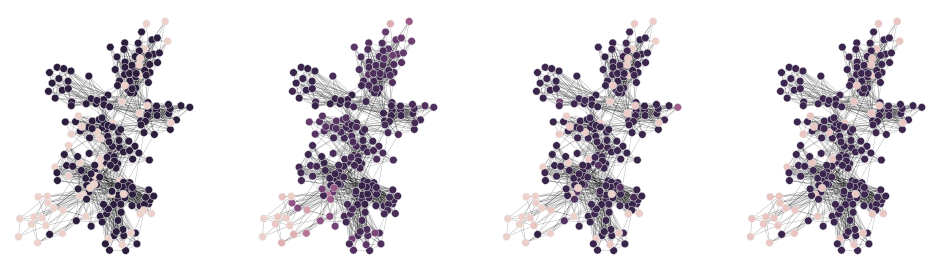

19 :


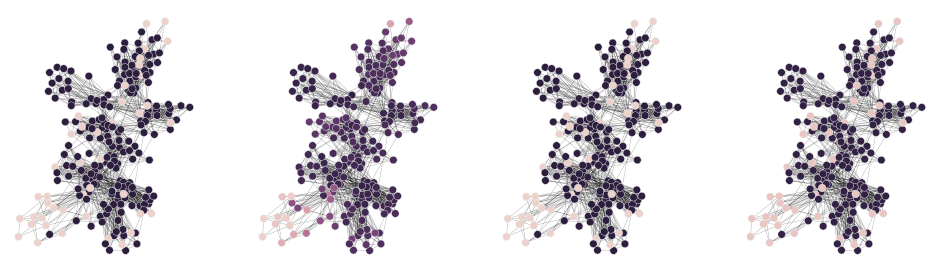

aggregated:


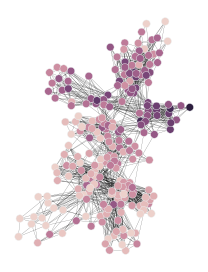

In [8]:

from tqdm.auto import trange
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)

step=20
kk = np.random.randint(1000)

edge_index = res_all['aidx']
max_nodes = edge_index.max()+1#181

pos = res_all['pos']
cls = res_all['cls']

A = COO_to_matrix(edge_index, max_nodes).numpy()
graph = nx.from_numpy_matrix(A)
nx.set_node_attributes(graph, pos, "pos")
nx.set_node_attributes(graph, cls, "cls")

plt_idx = list(range(20))[::]

with tqdm(total=step) as pbar:
    print('\tGround Truth (sample#%d)\t\t'%kk+'\t\t\t'.join(model_dispnames))

    for day in range(step):
        pbar.update(1)

        if not day in plt_idx:
            continue
        else:
            nn = plt_idx.index(day)
            print(day,':')

        fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10,3), dpi=100)

        color_map = []
        for i,_ in enumerate(graph):
            color_map.append(cmap(res_all['yt']['CVAE_UNET'][kk,i,day]))    

        nx.draw(graph, pos=pos, 
                node_color=color_map, node_size=30, width=.1,  ax=ax[0])#, with_labels=True, font_color='white')
        ax[0].set_ylabel('Step %d'%day)

        ##

        for mm,mstr in enumerate(models):

            y_true = res_all['yt'][mstr].flatten()
            y_probas = res_all['yp'][mstr].flatten()
    #         th = Find_Optimal_Cutoff(y_true,y_probas)

            color_map = []
            for i,_ in enumerate(graph):
                color_map.append(cmap(res_all['yp'][mstr][kk,i,day]))

            nx.draw(graph, pos=pos, 
                    node_color=color_map, node_size=30, width=.1, ax=ax[mm+1])#, with_labels=True, font_color='white')

        [a.collections[0].set_edgecolor('#ECF0F1') for a in ax]
        [a.collections[0].set_linewidths(.3) for a in ax]
        [a.set_aspect('equal', adjustable='box') for a in ax]

        fig.tight_layout()
        plt.show()


    # draw the aggregated graph:
    print('aggregated:')

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3), dpi=100)

    color_map = []
    for i,_ in enumerate(graph):
        color_map.append(cmap(res_all['yt']['CVAE_UNET'][kk,i,:].mean(-1)))

    nx.draw(graph, pos=pos, node_color=color_map, node_size=30, width=.1,  ax=ax)

    ax.collections[0].set_edgecolor('#ECF0F1')
    ax.collections[0].set_linewidths(.3)
    ax.set_aspect('equal', adjustable='box')

    fig.tight_layout()
    plt.show()        



## 4) the other metric: top-n localization accuracy


In [10]:
from collections import defaultdict

def top_n_idx(arr,n):
    idx = (-np.array(arr)).argsort()[:n]
    return idx


YT = res_all['yt']
YP = res_all['yp']
ind2cls = nx.get_node_attributes(graph, "cls")
cls2ind = defaultdict(list)
for key, value in ind2cls.items():
    cls2ind[value].append(key)
    
data = []

true_size = []
for tn in tqdm([1,3,5]):
    correct = {}
    
    with tqdm(total=YT[mstr].shape[0]*len(models), desc='top-%d'%tn) as pbar:
        
        for mstr in models:#'CVAE_UNET'
            th = .5#Find_Optimal_Cutoff(YT[mstr].flatten(),YP[mstr].flatten())[0]
    #         print(mstr, th)
            correct[mstr] = []

            for kk in range(YT[mstr].shape[0]):
                pbar.update(1)

                cls_inf = []
                for ss in range(YT[mstr][kk].shape[-1]):                    
                    yy_t = YT[mstr][kk][:,ss] # all nodes of step #ss
                    yy_p = YP[mstr][kk][:,ss]

                    classes, true_mean = [], []
                    pred_mean, pred_max = [], []

                    check_len = len(cls_inf)
                    for cc,ii in cls2ind.items():
                        #yy_t[np.array(ii)]
                        if check_len < 1 and ss < 1:
                            if np.any(yy_t[np.array(ii)]) and cc not in cls_inf:
                                cls_inf.append(cc)

                        true_mean.append(np.mean(yy_t[np.array(ii)]))
                        pred_max.append(np.max(yy_p[np.array(ii)]))
                        pred_mean.append(np.mean(yy_p[np.array(ii)]))
                        classes.append(cc)

                    if np.max(pred_max)<th:
                        continue

                    try:
                        cls_inf = cls_inf[:3]
                    except:
                        pass
                        
                    classes = np.array(classes)
                    true_mean = np.array(true_mean)
                    pred_max = np.array(pred_max)
                    pred_mean = np.array(pred_mean)

                    pmxi = top_n_idx(pred_max,tn) #np.argmax(pred_max) 

                    correct[mstr].append(len(np.intersect1d(cls_inf,classes[pmxi]))/len(cls_inf))
                    
                    true_size.append(len(cls_inf))
                    break

    topn_acc = [np.sum(np.array(correct[mstr])>0)/len(correct[mstr]) for mstr in models]
    data.append(topn_acc)
    
df = pd.DataFrame(data, columns=model_dispnames, index=['top-%d'%n for n in [1,3,5]])
df

DDmix  CNN-nodes  CNN-time
top-1  0.259259   0.128074  0.115779
top-3  0.612140   0.367828  0.304303
top-5  0.829218   0.600410  0.534836